In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import re
import keras
from keras.utils import pad_sequences
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import nltk
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from keras.layers import Activation, Dense, Dropout, Input, Embedding
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df=pd.read_csv("Data.csv")

In [ ]:
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
df.isnull().any()

Category    False
Message     False
dtype: bool

In [ ]:
def most_frequent_word(df, type):
    wc = WordCloud(width = 512, height = 512)
    if type == 'spam':
        spam_words = ''.join(list(df[df['Category'] == 'spam']['Message'] ))
        spam_wc = wc.generate(spam_words)
        plt.figure(figsize= (10,8), facecolor= 'k')
        plt.imshow(spam_wc)

    elif type == 'ham':
        ham_words = ''.join(list(df[df['Category'] == 'ham']['Message'] ))
        ham_wc = wc.generate(ham_words)
        plt.figure(figsize= (10,8), facecolor= 'k')
        plt.imshow(ham_wc)

    plt.axis('off')
    plt.tight_layout(pad = 0)
    plt.show()

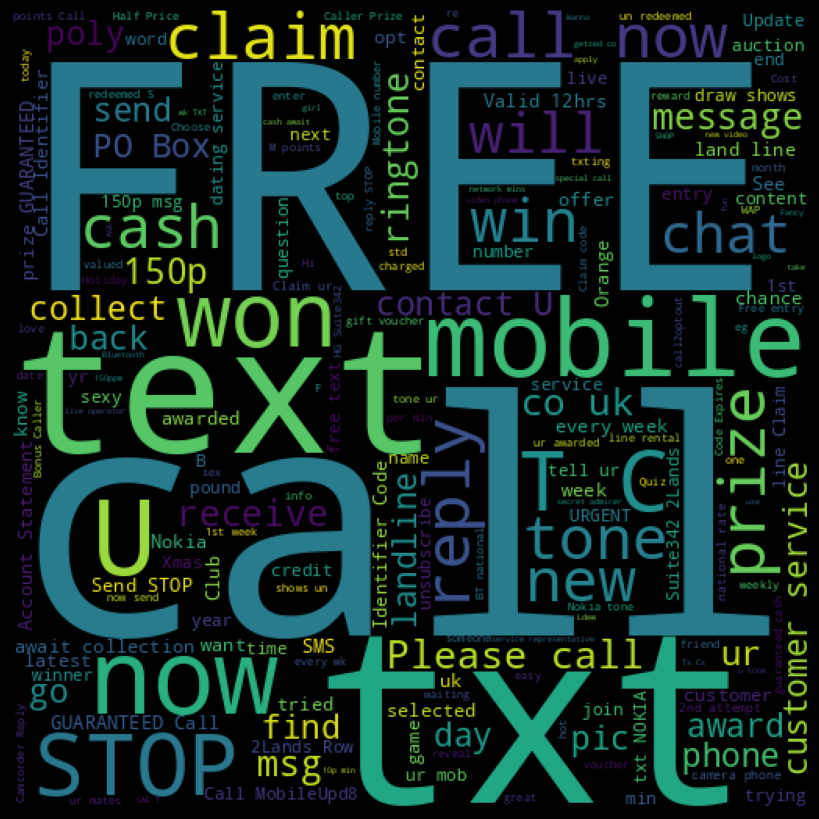

In [ ]:
most_frequent_word(df, 'spam')

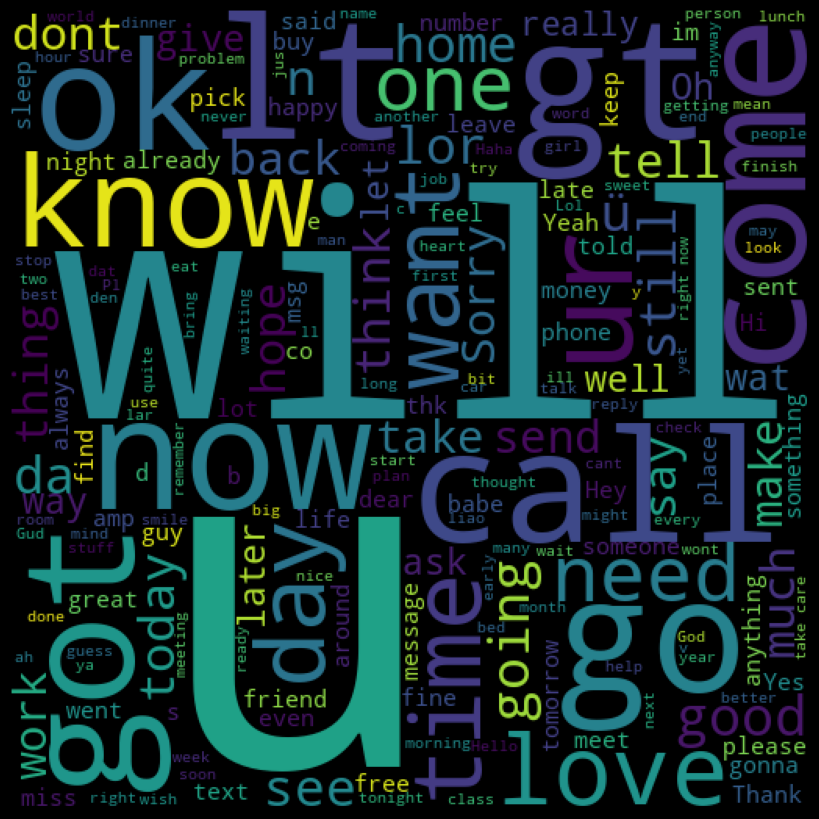

In [ ]:
most_frequent_word(df, 'ham')

In [ ]:
df['Category']=[1 if df.loc[i, 'Category']=='spam' else 0 for i in range(5572)]

In [ ]:
df['Category'].value_counts()

0    4825
1     747
Name: Category, dtype: int64

In [ ]:
df

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [ ]:
df['Category'].describe()

count    5572.000000
mean        0.134063
std         0.340751
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Category, dtype: float64

<Axes: xlabel='Category', ylabel='count'>

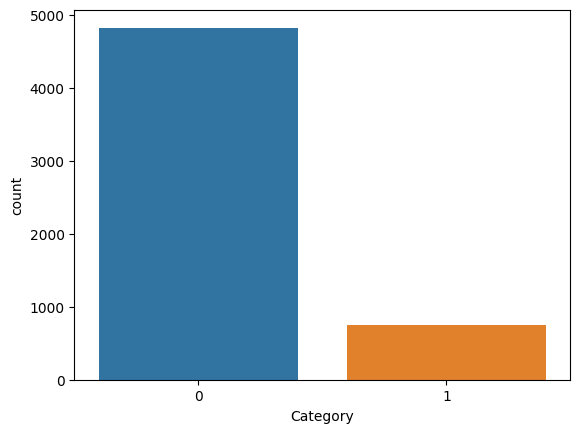

In [ ]:
sns.countplot(x=df['Category'])

In [ ]:
def ngrams(corpus, ngram_range = (1,1), n= None):
    vec = CountVectorizer(ngram_range = ngram_range, stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0)
    word_freq = [(word, sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    word_freq = sorted(word_freq, key = lambda x: x[1], reverse = True)
    return word_freq[:n]

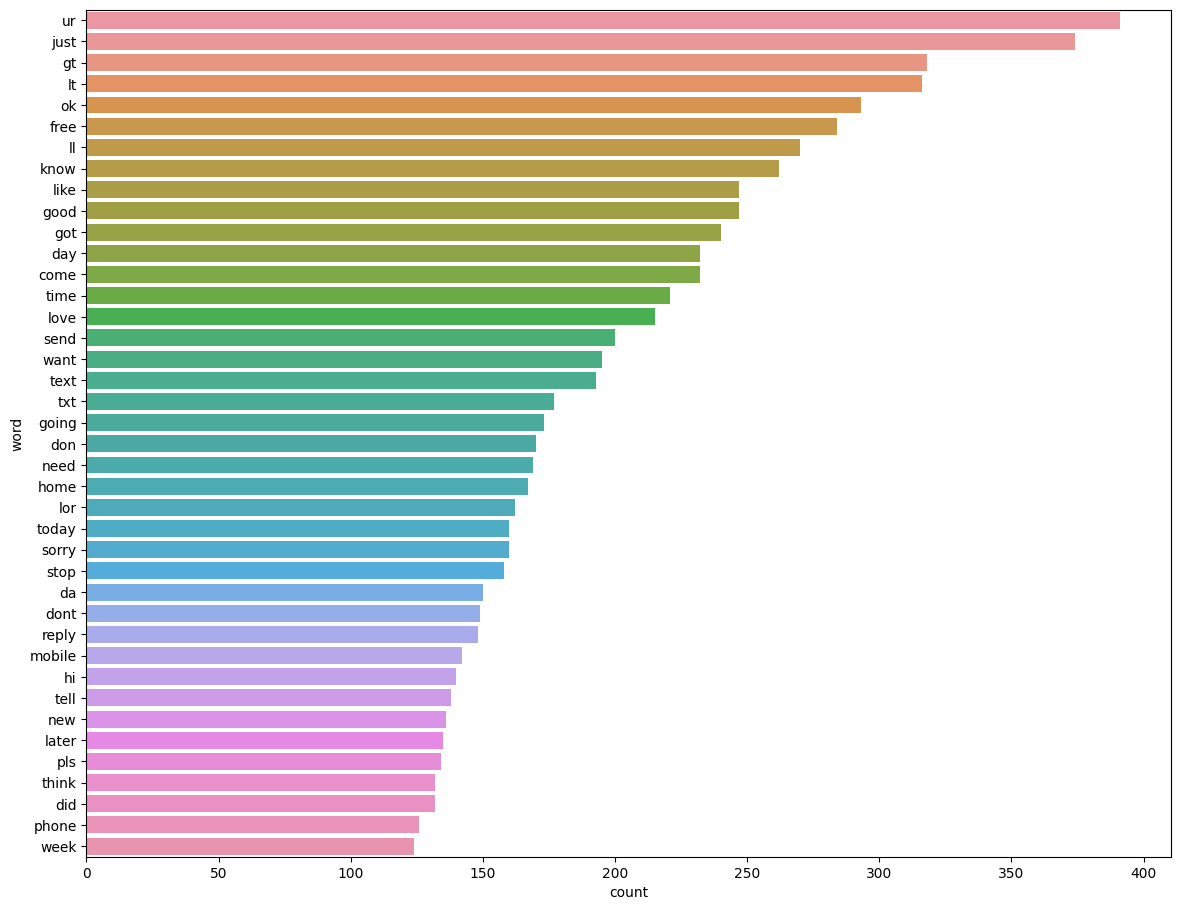

In [ ]:
unigram = ngrams(df['Message'],(1,1),40)


df1 = pd.DataFrame(unigram, columns = ['word','count'])



plt.figure(figsize=(14,11))
sns.barplot(data=df1,y = df1['word'], x=df1['count'])
plt.show()

# 2-gram


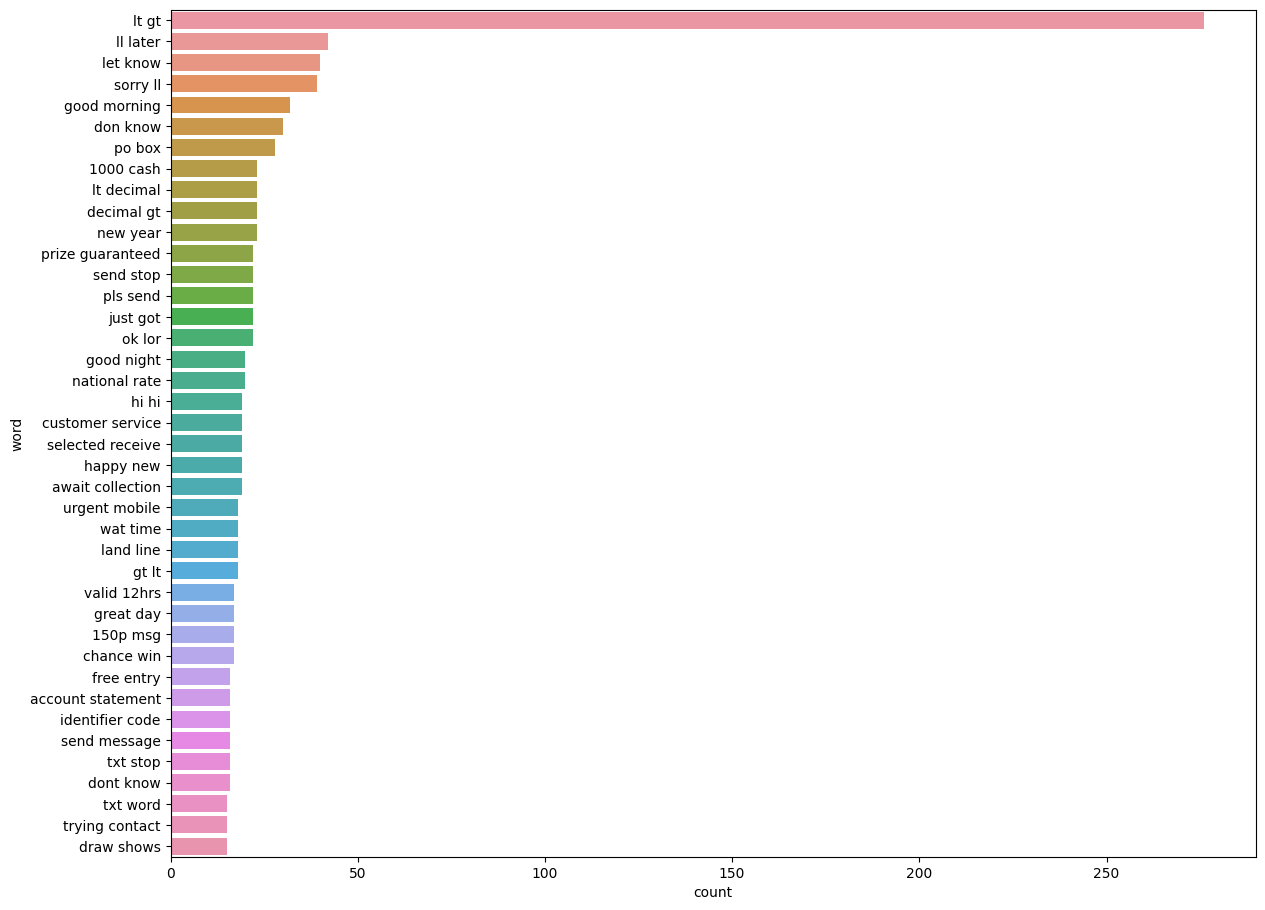

In [ ]:
unigram = ngrams(df['Message'],(2,2),40)


df1 = pd.DataFrame(unigram, columns = ['word','count'])



plt.figure(figsize=(14,11))
sns.barplot(data=df1,y = df1['word'], x=df1['count'])
plt.show()

# 3-gram

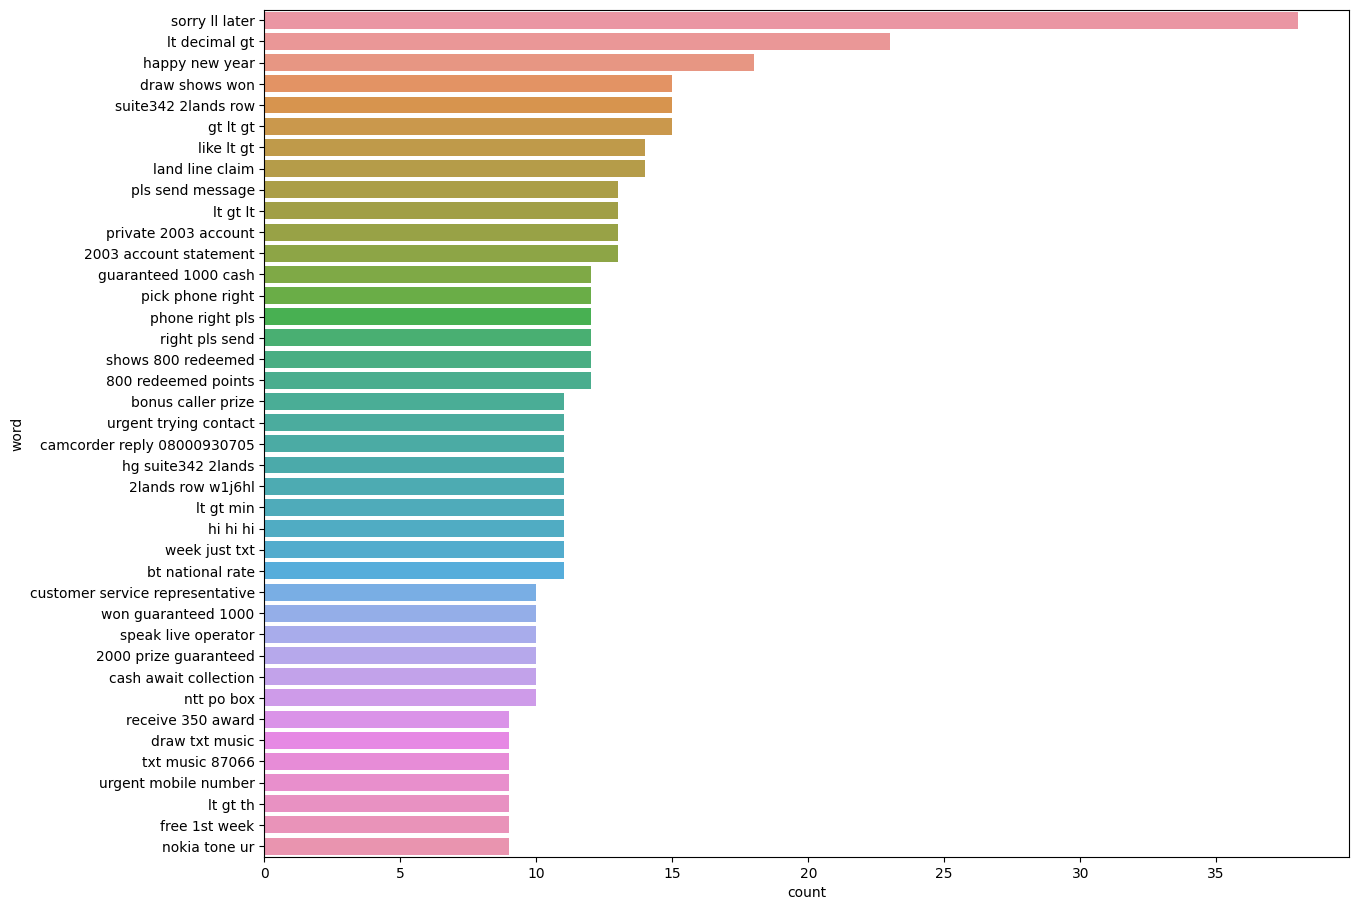

In [ ]:
unigram = ngrams(df['Message'],(3,3),40)


df1 = pd.DataFrame(unigram, columns = ['word','count'])



plt.figure(figsize=(14,11))
sns.barplot(data=df1,y = df1['word'], x=df1['count'])
plt.show()

Количество единиц сильно меньше количества нулей, в связи с этим применим стратификацию

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['Message'], df['Category'], test_size=0.2, random_state=42, stratify=df['Category'])

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

<Axes: xlabel='Category', ylabel='count'>

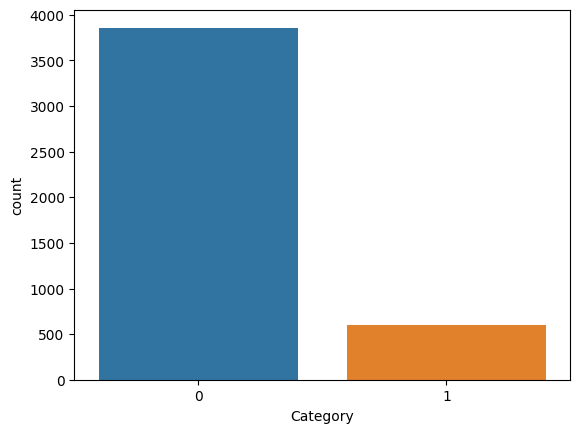

In [ ]:
sns.countplot(x=y_train)

<Axes: xlabel='Category', ylabel='count'>

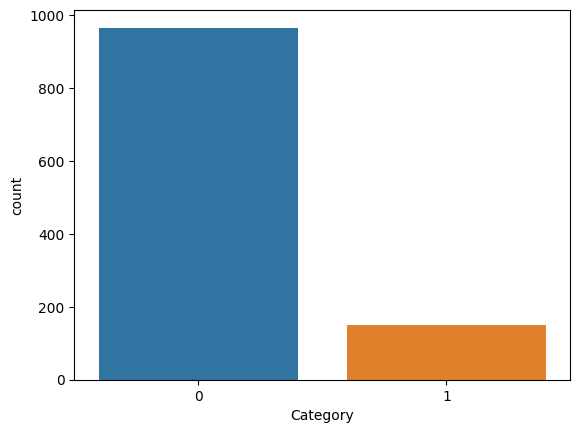

In [ ]:
sns.countplot(x=y_test)

In [ ]:
X_train

0                                He will, you guys close?
1       CAN I PLEASE COME UP NOW IMIN TOWN.DONTMATTER ...
2                 Ok k..sry i knw 2 siva..tats y i askd..
3                               I'll see, but prolly yeah
4       I'll see if I can swing by in a bit, got some ...
                              ...                        
4452                  What pa tell me.. I went to bath:-)
4453                         Jus finish watching tv... U?
4454    Moby Pub Quiz.Win a £100 High Street prize if ...
4455    Free entry in 2 a weekly comp for a chance to ...
4456    We are at grandmas. Oh dear, u still ill? I fe...
Name: Message, Length: 4457, dtype: object

In [ ]:
train_length=pd.Series([len(str(X_train[i])) for i in range(X_train.shape[0])])

In [ ]:
test_length=pd.Series([len(str(X_test[i])) for i in range(X_test.shape[0])])

In [ ]:
train_length.describe()

count    4457.000000
mean       79.821180
std        58.334462
min         2.000000
25%        36.000000
50%        61.000000
75%       122.000000
max       910.000000
dtype: float64

In [ ]:
test_length.describe()

count    1115.000000
mean       82.558744
std        65.892185
min         3.000000
25%        35.000000
50%        63.000000
75%       124.000000
max       790.000000
dtype: float64

# **Обработка данных для обучения**

In [ ]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()


def data_preprocessing(messy_string):
    cleaned = re.sub(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b', 'emailaddr', messy_string)
    cleaned = re.sub(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'httpaddr',
                     cleaned)
    cleaned = re.sub(r'£|\$', 'moneysymb', cleaned)
    cleaned = re.sub(
        r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b',
        'phonenumbr', cleaned)
    cleaned = re.sub(r'\d+(\.\d+)?', 'numbr', cleaned)
    cleaned = re.sub(r'[^\w\d\s]', ' ', cleaned)
    cleaned = re.sub(r'\s+', ' ', cleaned)
    cleaned = re.sub(r'^\s+|\s+?$', '', cleaned.lower())

    cleaned = cleaned.lower()

    # tokenization
    tokens = nltk.word_tokenize(cleaned)
    cleaned = [word for word in tokens if word not in stop_words]
    cleaned = [lemmatizer.lemmatize(word) for word in cleaned]
    cleaned = ' '.join(cleaned)

    return cleaned

In [ ]:
X_train=[ str(data_preprocessing(X_train[i])) for i in range(X_train.shape[0])]

In [ ]:
X_train

['guy close',
 'please come imin httpaddr urgoin outlnumbrr reallyneed httpaddr dontplease dontignore mycalls u thecd httpaddr tome numbr numbrmoro',
 'ok k sry knw numbr siva tat askd',
 'see prolly yeah',
 'see swing bit got thing take care firsg',
 'shall book chez jules half eight ok',
 'thanks message really appreciate sacrifice sure process direct pay find way back test tomorrow class wonderful day',
 'feb lt gt love u day send dis ur valued frnds evn numbr come back u gt married person u luv u ignore dis u lose ur luv numbr evr',
 'ok chinese food way get fat paying lipo',
 'free nokia motorola upto numbrmths numbr numbrprice linerental numbr free x net min numbrtxt mth free b tooth call mobileupdnumbr phonenumbr call numbroptout dnumbrwv',
 'jus came back fr lunch wif si u leh',
 'yup elaborating safety aspect issue',
 'ok lor anyway thk cant get ticket co like quite late already u wan numbr go look numbr ur frens darren wif',
 'helloooo wake sweet morning welcome enjoy day ful

In [ ]:
def vect(max_tokens, data):
  text_vectorizer = keras.layers.TextVectorization()
  text_vectorizer.adapt(data)

  dat1=text_vectorizer(data)

  return dat1
X_train_data=vect(250, X_train)
#X_valid_data=vect(250, X_valid)
X_test_data=vect(250, X_test)
tf.keras.preprocessing.sequence.pad_sequences (X_train_data, maxlen=X_test_data.shape[1],padding = "post")

X_train_data.shape, X_test_data.shape

(TensorShape([4457, 77]), TensorShape([1115, 162]))

# *Обработка с помощью Tfidf*




In [ ]:
vec = TfidfVectorizer(ngram_range=(1,1))
vec.fit(X_train)

X_train_data = vec.transform(X_train)
X_test_data = vec.transform(X_test)

print(X_train_data)

  (0, 2284)	0.6412910616392663
  (0, 996)	0.7672977090162478
  (1, 5878)	0.2871958189550952
  (1, 5647)	0.2871958189550952
  (1, 5539)	0.2871958189550952
  (1, 4472)	0.2871958189550952
  (1, 4151)	0.15690066436754294
  (1, 3950)	0.2871958189550952
  (1, 3726)	0.2643387831771532
  (1, 3658)	0.08537453048992574
  (1, 3494)	0.2871958189550952
  (1, 2585)	0.2871958189550952
  (1, 2506)	0.3702818549593348
  (1, 1502)	0.2871958189550952
  (1, 1501)	0.2871958189550952
  (1, 1047)	0.13702839425956218
  (2, 5455)	0.41630785052315544
  (2, 5211)	0.45571274773186654
  (2, 5000)	0.47206725772870994
  (2, 3870)	0.23027342228001926
  (2, 3658)	0.14718332818309177
  (2, 2883)	0.39820399481632096
  (2, 323)	0.4036223070355227
  (3, 6288)	0.4567485964997718
  (3, 4806)	0.4159385845103801
  :	:
  (4455, 4180)	0.2771378256873015
  (4455, 4105)	0.13129711778358416
  (4455, 3658)	0.27621374371129354
  (4455, 2684)	0.2562347652030849
  (4455, 2138)	0.13213111337814673
  (4455, 2024)	0.14989767940445073
  (4

In [ ]:
model=XGBClassifier()
model.fit(X_train_data,y_train)
y_pred=model.predict(X_test_data)

f1_score(y_test, y_pred, average='macro')

0.6564346126057206

In [ ]:
model2=RandomForestClassifier()
model2.fit(X_train_data, y_train)
y_pred=model.predict(X_test_data)

f1_score(y_test, y_pred, average='macro')

0.6564346126057206

In [ ]:
nb = MultinomialNB()
nb.fit(X_train_data, y_train)
y_pred = nb.predict(X_test_data)

f1_score(y_test, y_pred, average='macro')

0.8900104483531261

# *2-gram*

In [ ]:
vec = TfidfVectorizer(ngram_range=(2,2))
vec.fit(X_train)

X_train_data = vec.transform(X_train)
X_test_data = vec.transform(X_test)


print(X_train_data)

  (0, 8487)	1.0
  (1, 22907)	0.259524463929
  (1, 22030)	0.259524463929
  (1, 21363)	0.259524463929
  (1, 17606)	0.259524463929
  (1, 16727)	0.23886970656220188
  (1, 15957)	0.259524463929
  (1, 14807)	0.259524463929
  (1, 13691)	0.259524463929
  (1, 10006)	0.259524463929
  (1, 9751)	0.259524463929
  (1, 9745)	0.259524463929
  (1, 9610)	0.259524463929
  (1, 5084)	0.259524463929
  (1, 5083)	0.259524463929
  (1, 3499)	0.259524463929
  (2, 20917)	0.4082482904638631
  (2, 20062)	0.4082482904638631
  (2, 19373)	0.4082482904638631
  (2, 15595)	0.4082482904638631
  (2, 14931)	0.4082482904638631
  (2, 10818)	0.4082482904638631
  (3, 18674)	0.7071067811865476
  (3, 17209)	0.7071067811865476
  (4, 21442)	0.3978796030327239
  :	:
  (4455, 16425)	0.23398692625972603
  (4455, 15045)	0.23398692625972603
  (4455, 14628)	0.19236315828739262
  (4455, 10183)	0.24068685642240947
  (4455, 7226)	0.24068685642240947
  (4455, 6721)	0.20770080073497613
  (4455, 5672)	0.24068685642240947
  (4455, 5670)	0.20529

In [ ]:
nb = MultinomialNB()
nb.fit(X_train_data, y_train)
y_pred = nb.predict(X_test_data)

f1_score(y_test, y_pred, average='macro')

0.6849376148739206

# *3-gram*

In [ ]:
vec = TfidfVectorizer(ngram_range=(3,3))
vec.fit(X_train)

X_train_data = vec.transform(X_train)
X_test_data = vec.transform(X_test)


print(X_train_data)

  (1, 23305)	0.2672612419124244
  (1, 22415)	0.2672612419124244
  (1, 21760)	0.2672612419124244
  (1, 18162)	0.2672612419124244
  (1, 17290)	0.2672612419124244
  (1, 16541)	0.2672612419124244
  (1, 13863)	0.2672612419124244
  (1, 10101)	0.2672612419124244
  (1, 9848)	0.2672612419124244
  (1, 9842)	0.2672612419124244
  (1, 9676)	0.2672612419124244
  (1, 4998)	0.2672612419124244
  (1, 4997)	0.2672612419124244
  (1, 3432)	0.2672612419124244
  (2, 20494)	0.4472135954999579
  (2, 19842)	0.4472135954999579
  (2, 16186)	0.4472135954999579
  (2, 15438)	0.4472135954999579
  (2, 10866)	0.4472135954999579
  (3, 19161)	1.0
  (4, 21837)	0.4082482904638631
  (4, 21164)	0.4082482904638631
  (4, 21104)	0.4082482904638631
  (4, 19169)	0.4082482904638631
  (4, 8175)	0.4082482904638631
  :	:
  (4455, 18002)	0.23807354867258032
  (4455, 17456)	0.23807354867258032
  (4455, 17004)	0.23807354867258032
  (4455, 15598)	0.23807354867258032
  (4455, 14904)	0.23807354867258032
  (4455, 10266)	0.23807354867258032


In [ ]:
nb = MultinomialNB()
nb.fit(X_train_data, y_train)

y_pred = nb.predict(X_test_data)
f1_score(y_test, y_pred, average='macro')

0.5169467309447214

# *Обработка с помощью CountVectorizer*




In [ ]:
vec = CountVectorizer(ngram_range=(1,1))
vec.fit(X_train)

X_train_data = vec.transform(X_train)
X_test_data = vec.transform(X_test)

print(X_train_data)

  (0, 996)	1
  (0, 2284)	1
  (1, 1047)	1
  (1, 1501)	1
  (1, 1502)	1
  (1, 2506)	3
  (1, 2585)	1
  (1, 3494)	1
  (1, 3658)	1
  (1, 3726)	1
  (1, 3950)	1
  (1, 4151)	1
  (1, 4472)	1
  (1, 5539)	1
  (1, 5647)	1
  (1, 5878)	1
  (2, 323)	1
  (2, 2883)	1
  (2, 3658)	1
  (2, 3870)	1
  (2, 5000)	1
  (2, 5211)	1
  (2, 5455)	1
  (3, 4331)	1
  (3, 4806)	1
  :	:
  (4455, 2024)	1
  (4455, 2138)	1
  (4455, 2684)	1
  (4455, 3658)	3
  (4455, 4105)	1
  (4455, 4180)	1
  (4455, 4443)	1
  (4455, 5244)	1
  (4455, 5772)	2
  (4455, 6073)	1
  (4455, 6137)	1
  (4456, 224)	1
  (4456, 1306)	1
  (4456, 1872)	1
  (4456, 2226)	1
  (4456, 2521)	1
  (4456, 2577)	1
  (4456, 2967)	1
  (4456, 3428)	1
  (4456, 3586)	1
  (4456, 3865)	1
  (4456, 4741)	1
  (4456, 4910)	1
  (4456, 5260)	1
  (4456, 5559)	1


In [ ]:
model=XGBClassifier()
model.fit(X_train_data,y_train)
y_pred=model.predict(X_test_data)

f1_score(y_test, y_pred, average='macro')

0.6373983739837399

In [ ]:
model2=RandomForestClassifier()
model2.fit(X_train_data, y_train)
y_pred=model.predict(X_test_data)

f1_score(y_test, y_pred, average='macro')

0.6373983739837399

In [ ]:
nb = MultinomialNB()
nb.fit(X_train_data, y_train)
y_pred = nb.predict(X_test_data)

f1_score(y_test, y_pred, average='macro')

0.9500126425424242

# *2-gram*

In [ ]:
vec = CountVectorizer(ngram_range=(2,2))
vec.fit(X_train)

X_train_data = vec.transform(X_train)
X_test_data = vec.transform(X_test)


print(X_train_data)

  (0, 8487)	1
  (1, 3499)	1
  (1, 5083)	1
  (1, 5084)	1
  (1, 9610)	1
  (1, 9745)	1
  (1, 9751)	1
  (1, 10006)	1
  (1, 13691)	1
  (1, 14807)	1
  (1, 15957)	1
  (1, 16727)	1
  (1, 17606)	1
  (1, 21363)	1
  (1, 22030)	1
  (1, 22907)	1
  (2, 10818)	1
  (2, 14931)	1
  (2, 15595)	1
  (2, 19373)	1
  (2, 20062)	1
  (2, 20917)	1
  (3, 17209)	1
  (3, 18674)	1
  (4, 1860)	1
  :	:
  (4455, 7226)	1
  (4455, 10183)	1
  (4455, 14628)	1
  (4455, 15045)	1
  (4455, 16425)	1
  (4455, 16868)	1
  (4455, 17445)	1
  (4455, 20192)	1
  (4455, 22522)	1
  (4455, 22525)	1
  (4455, 23754)	1
  (4455, 24039)	1
  (4456, 727)	1
  (4456, 4544)	1
  (4456, 6221)	1
  (4456, 8173)	1
  (4456, 9796)	1
  (4456, 9917)	1
  (4456, 11121)	1
  (4456, 13385)	1
  (4456, 14202)	1
  (4456, 15468)	1
  (4456, 19102)	1
  (4456, 20254)	1
  (4456, 21484)	1


In [ ]:
nb = MultinomialNB()
nb.fit(X_train_data, y_train)
y_pred = nb.predict(X_test_data)

f1_score(y_test, y_pred, average='macro')

0.9098431944085623

# *3-gram*

In [ ]:
vec = CountVectorizer(ngram_range=(3,3))
vec.fit(X_train)

X_train_data = vec.transform(X_train)
X_test_data = vec.transform(X_test)


print(X_train_data)

  (1, 3432)	1
  (1, 4997)	1
  (1, 4998)	1
  (1, 9676)	1
  (1, 9842)	1
  (1, 9848)	1
  (1, 10101)	1
  (1, 13863)	1
  (1, 16541)	1
  (1, 17290)	1
  (1, 18162)	1
  (1, 21760)	1
  (1, 22415)	1
  (1, 23305)	1
  (2, 10866)	1
  (2, 15438)	1
  (2, 16186)	1
  (2, 19842)	1
  (2, 20494)	1
  (3, 19161)	1
  (4, 1767)	1
  (4, 8175)	1
  (4, 19169)	1
  (4, 21104)	1
  (4, 21164)	1
  :	:
  (4455, 6578)	1
  (4455, 7084)	1
  (4455, 10266)	1
  (4455, 14904)	1
  (4455, 15598)	1
  (4455, 17004)	1
  (4455, 17456)	1
  (4455, 18002)	1
  (4455, 20606)	1
  (4455, 22874)	1
  (4455, 22877)	1
  (4455, 24187)	1
  (4455, 24466)	1
  (4456, 686)	1
  (4456, 4468)	1
  (4456, 6104)	1
  (4456, 8217)	1
  (4456, 9890)	1
  (4456, 10010)	1
  (4456, 13572)	1
  (4456, 14409)	1
  (4456, 16024)	1
  (4456, 19584)	1
  (4456, 20663)	1
  (4456, 21879)	1


In [ ]:
nb = MultinomialNB()
nb.fit(X_train_data, y_train)
y_pred = nb.predict(X_test_data)

f1_score(y_test, y_pred, average='macro')

0.7613986532755079

# Нейронная сеть



In [ ]:
max_words = 256
max_len = 256
tok = keras.preprocessing.text.Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences, maxlen=max_len)
print(sequences_matrix)

[[  0   0   0 ...   0   0 135]
 [  0   0   0 ...   2   4   1]
 [  0   0   0 ...  16  43   1]
 ...
 [  0   0   0 ...  38  11   1]
 [  0   0   0 ...  32   5   1]
 [  0   0   0 ...  51  58 151]]


In [ ]:
def Convo1d_model():
    inputs1 = Input(name='inputs1',shape=[max_len])
    layer = Embedding(max_words, 128, input_length=max_len)(inputs1)
    layer = tf.keras.layers.Conv1D(max_len, 3, input_shape=[max_len])(layer)
    layer = tf.keras.layers.Conv1D(max_len, 4, activation='relu')(layer)
    layer = tf.keras.layers.Conv1D(max_len, 5, activation='relu')(layer)
    layer = tf.keras.layers.Conv1D(max_len, 6, activation='relu')(layer)
    layer = tf.keras.layers.GlobalAvgPool1D()(layer)
    layer = Dense(128, activation='relu')(layer)
    layer = Dense(1, name='out_layer', activation='sigmoid')(layer)
    model = Model(inputs=inputs1,outputs=layer)
    return model

model = Convo1d_model()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[tf.keras.metrics.BinaryAccuracy()])



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs1 (InputLayer)        [(None, 256)]             0         
                                                                 
 embedding (Embedding)       (None, 256, 128)          32768     
                                                                 
 conv1d (Conv1D)             (None, 254, 256)          98560     
                                                                 
 conv1d_1 (Conv1D)           (None, 251, 256)          262400    
                                                                 
 conv1d_2 (Conv1D)           (None, 247, 256)          327936    
                                                                 
 conv1d_3 (Conv1D)           (None, 242, 256)          393472    
                                                                 
 global_average_pooling1d (G  (None, 256)              0     

Epoch 1/15
112/112 [==============================] - 167s 1s/step - loss: 0.0572 - binary_accuracy: 0.9868 - val_loss: 0.2426 - val_binary_accuracy: 0.9619
Epoch 2/15
112/112 [==============================] - 157s 1s/step - loss: 0.0555 - binary_accuracy: 0.9863 - val_loss: 0.1101 - val_binary_accuracy: 0.9753
Epoch 3/15
112/112 [==============================] - 145s 1s/step - loss: 0.0475 - binary_accuracy: 0.9888 - val_loss: 0.1418 - val_binary_accuracy: 0.9720


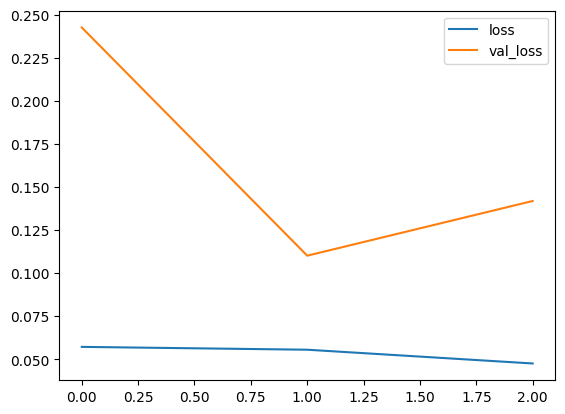

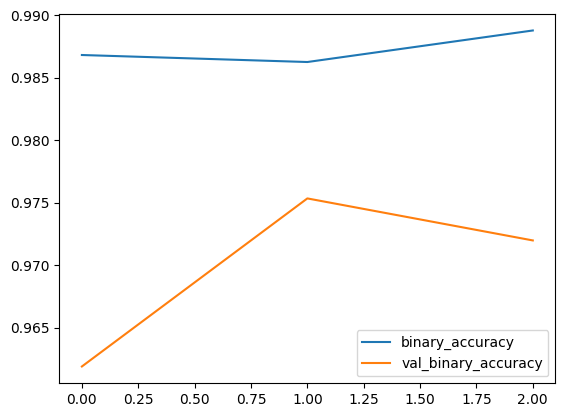

In [ ]:
history = model.fit(sequences_matrix,y_train,batch_size=32, epochs=15,
          validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.00001)])


test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)


hist = pd.DataFrame(history.history)
hist.loc[:, ['loss', 'val_loss']].plot()
hist.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [ ]:
accr = model.evaluate(test_sequences_matrix, y_test)

35/35 [==============================] - 12s 356ms/step - loss: 0.2286 - binary_accuracy: 0.9534
